# SRGAN
---

SRGAN을 이용하여 다양한 high resolution 실험을 수행하여 본다.

## STEP 0. 설계
---

#### 프로젝트 1. 직접 고른 이미지로 SRGAN 실험하기
1. 고해상도 이미지를 이용한 SRGAN 
    1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러온다.
    2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄인다. `cv2.resize()`를 사용해 본다.
    3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성한다. 이전에 사용한 `apply_srgan` 함수를 사용하면 쉽다.
    4. 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘린다. 마찬가지로 `cv2.resize()`를 사용해 보자.
    5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화한다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시한다.
    6. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 보자.
2. 저해상도 이미지를 이용한 SRGAN 
    1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러온다.
    2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성한다. 이전에 사용한 `apply_srgan` 함수를 사용하면 쉽다.
    3. 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘린다. `cv2.resize()`를 사용해 보자.
    4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화한다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 준다.
    5. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 보자.

#### 프로젝트 2. SRGAN을 이용해 고해상도 gif 생성하기
1. gif 파일 불러오기
    - gif 파일을 불러와 프레임별 이미지를 추출한다.
2. 프레임별 Super Resolution 진행하기
    - Bicubic interpolation과 SRGAN을 이용해 각각의 가로, 세로 픽셀 수를 4배로 늘린다.
3. 프레임을 합쳐 gif 만들기
    - Bicubic 및 SRGAN의 결과를 각각 저장하여 2개의 gif 파일을 생성한다.

#### environment setting

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import tensorflow as tf
import imageio
from tqdm import tqdm
from IPython.display import Image
from IPython.display import Image as show_gif

In [24]:
# initialization gpu ########################################################
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e, "\n\n")
init_gpu()

1 Physical GPUs, 1 Logical GPUs




In [25]:
workspace_path = '/home/aiffel-dj1/workspace/aiffel-exploration-workspace/E16_super_resolution'
img_dir_path = workspace_path + '/img'
model_dir_path = workspace_path + '/model'

#### 이미지 수집

In [ ]:
! ls {img_dir_path}

metro_lr.gif  sunflower_1024_683.jpg  sunflower_400_300.jpg  wine_lr.gif


## STEP 1. 프로젝트 1-1. 고해상도 이미지를 이용한 SRGAN 
---

- 고해상도 이미지를 한 장 불러온다.

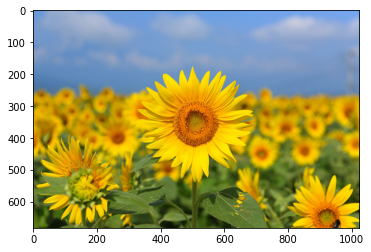

In [ ]:
HR = load_image(img_dir_path + '/sunflower_1024_683.jpg')
show_image(HR)

- 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄인다.

[ scaling - 0.25 ] img shape before : (1024, 683)
[ scaling - 0.25 ] img shape after : (256, 171)


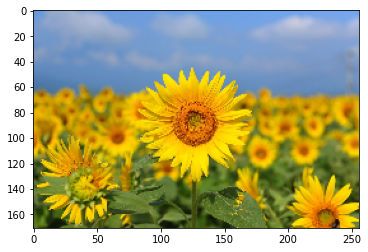

In [ ]:
LR = bicubic(HR, 0.25, 1)
show_image(LR)

- 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성한다.
- 모델에는 이미지의 크기는 2배로 upsampling하는 2개의 PixelShuffler이 존재하므로, 모델의 예측 결과의 크기는 입력된 이미지의 크기의 4배가 된다.


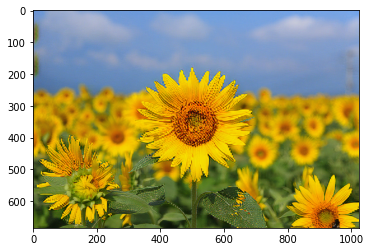

LR shape : 256, 171
HR shape: 1024, 683


In [ ]:
srgan = load_srgan_model(model_dir_path + '/srgan_G.h5')
srgan_img_p1 = apply_srgan(LR, srgan)
show_image(srgan_img_p1)

print(f'LR shape : {LR.shape[1]}, {LR.shape[0]}')
print(f'HR shape: {srgan_img_p1.shape[1]}, {srgan_img_p1.shape[0]}')

- `LR`에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘린다.

[ scaling - 4 ] img shape before : (256, 171)
[ scaling - 4 ] img shape after : (1024, 684)


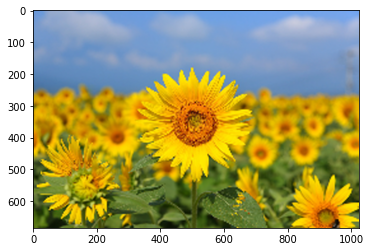

In [ ]:
bicubic_img_p1 = bicubic(LR, 4, 1)
show_image(bicubic_img_p1)

-  결과 확인

/usr/local/lib/python3.7/dist-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


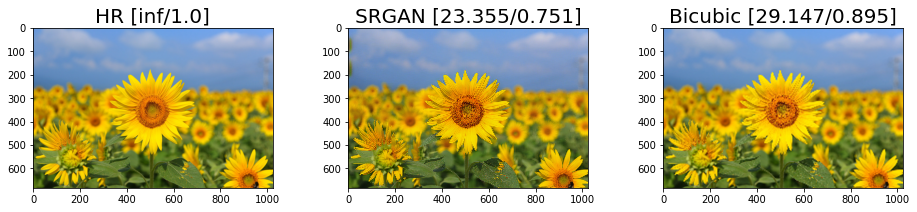

In [ ]:
show_project_result_with_score([HR, srgan_img_p1, bicubic_img_p1], 
                               ['HR', 'SRGAN', 'Bicubic'],
                               [[0,0]],
                               HR.shape[1], HR.shape[0])

/usr/local/lib/python3.7/dist-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


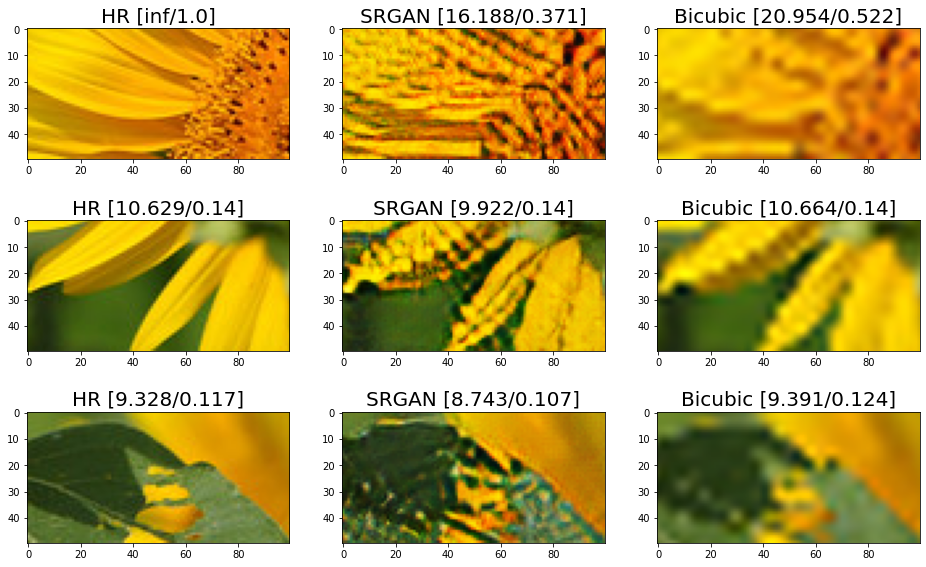

In [ ]:
show_project_result_with_score([HR, srgan_img_p1, bicubic_img_p1], 
                               ['HR', 'SRGAN', 'Bicubic'],
                               [[380,300], [50, 600], [600, 550]],
                               100, 50)

- 이미지가 선명하다는 것을 이미지에 등장하는 객체의 경계가 뚜렷하다는 것이라고 생각한다면, SRGAN으로 생성한 이미지가 Bicubic를 이용하여 생성한 이미지 보다 선명하다고 할 수 있다.
- Bicubic를 이용하여 생성된 이미지는 경계가 명확하지 않다고 느껴졌다. 이는 보간법이 주위 픽셀값으로부터 확장된 픽셀의 값을 채우기 때문에 픽셀들의 값이 유사하게 형성이 되고 경계가 부드럽게 형성된 것이다.
- 육안상으로는 SRGAN의 결과가 더 좋다고 볼 수도 있으나 정량적 지표로는 반대의 결과를 확인할수 있었다. PSNR과 SSIM 모두 Bicubic으로 생성한 이미지가 더 높기 때문에 원본과의 유사도가 더 높은, 즉 성공적으로 super resolution이 이루어진 것은 Bicubic라고 볼 수 있다.
- 이번 실험결과를 보았을 때, SRGAN은 어두운/0에 가까운 픽셀들을 더 많이 확장하는 경향을 보였다. 모델의 Conv layer에서 padding의 옵션값을 same를 사용하는데, 해당 경우에는 zero padding이 들어가게 된다. 이 때문에 Conv layer를 통과한 이미지들의 검은색 영역이 확장된다고 생각 되었다.  하지만 이것도 추측일뿐, 정확한 사항은 확인이 필요하다🤔 

## STEP 2. 프로젝트 1-2. 저해상도 이미지를 이용한 SRGAN 
---

- 저해상도 이미지를 한 장 불러온다.

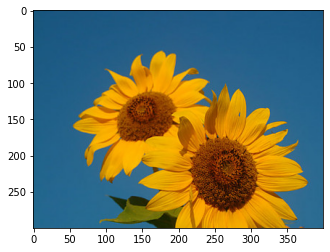

In [ ]:
LR = load_image(img_dir_path + '/sunflower_400_300.jpg')
show_image(LR)

- 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성한다.

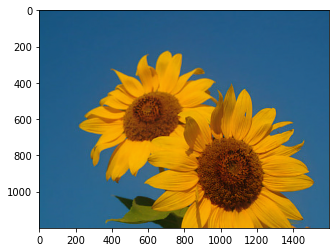

LR shape : 400, 300
HR shape: 1600, 1200


In [ ]:
srgan_img_p2 = apply_srgan(LR, srgan)
show_image(srgan_img_p2)

print(f'LR shape : {LR.shape[1]}, {LR.shape[0]}')
print(f'HR shape: {srgan_img_p2.shape[1]}, {srgan_img_p2.shape[0]}')

- 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘린다.

[ scaling - 4 ] img shape before : (400, 300)
[ scaling - 4 ] img shape after : (1600, 1200)


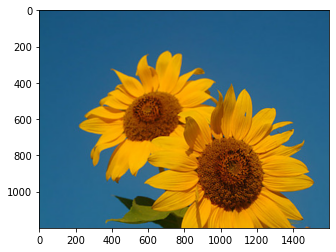

In [ ]:
bicubic_img_p2 = bicubic(LR, 4, 1)
show_image(bicubic_img_p2)

- 결과 확인

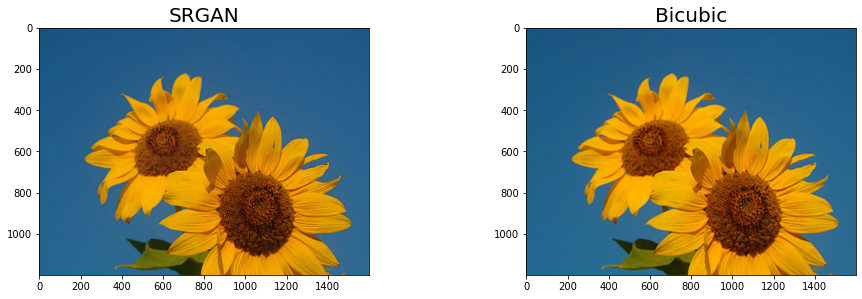

In [ ]:
show_project_result([srgan_img_p2, bicubic_img_p2], 
                    ['SRGAN', 'Bicubic'],
                    [[0,0]],
                    srgan_img_p2.shape[1], srgan_img_p2.shape[0])

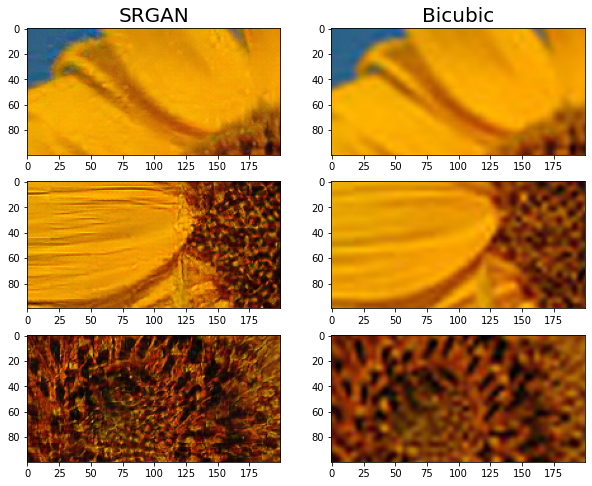

In [ ]:
show_project_result([srgan_img_p2, bicubic_img_p2], 
                    ['SRGAN', 'Bicubic'],
                    [[400,400], [750, 900], [1000, 800]],
                    200, 100,
                    figsize=(10,8))

- 이번 실험에서도 SRGAN으로 생성한 이미지가 Bicubic를 이용하여 생성한 이미지 보다 더 선명해 보였다.
- 원본 이미지가 생성된 이미지와 shape가 달라, PSNR와 SSIM을 확인할 수 없었다.

## STEP 3. 프로젝트 2
---

#### gif 파일 불러오기

- 불러오기

In [139]:
gif = get_VideoCapture(img_dir_path + '/metro_lr.gif')

- 프레임별 이미지를 추출

In [140]:
frames = get_frame(gif, verbose=1)

[get_frame] frame 수 : 35
[get_frame] frame 크기 : (252, 282, 3)


#### 프레임별 Super Resolution 진행

- Bicubic interpolation

In [125]:
frames_sr_bicubic = [ bicubic(x, 4) for x in tqdm(frames)]

100%|██████████| 20/20 [00:00<00:00, 840.17it/s]


- SRGAN

In [126]:
frames_sr_srgan = [ apply_srgan(x, srgan) for x in tqdm(frames)]

100%|██████████| 20/20 [00:05<00:00,  3.99it/s]


#### 프레임을 합쳐 gif 만들기

In [132]:
imageio.mimsave(img_dir_path + "/metro-bicubic.gif", frames_sr_bicubic, fps=25)
imageio.mimsave(img_dir_path + "/metro-srgan.gif", frames_sr_srgan, fps=25)

#### 결과 확인

In [141]:
! file ./img/metro.gif
! file ./img/metro-bicubic.gif
! file ./img/metro-srgan.gif

./img/metro.gif: cannot open `./img/metro.gif' (No such file or directory)
./img/metro-bicubic.gif: GIF image data, version 89a, 1128 x 1008
./img/metro-srgan.gif: GIF image data, version 89a, 1128 x 1008


- 원본

In [ ]:
# show_gif(img_dir_path + "/metro_lr.gif", width=600)
# 용량문제로 markdown으로 이미지 삽입

<img src="./img/metro_lr.gif" width=600px>

- bicubic

In [3]:
# show_gif(img_dir_path + "/metro-bicubic.gif", width=600)
# 용량문제로 markdown으로 이미지 삽입

<img src="./img/metro-bicubic.gif" width=600px>

- srgan

In [1]:
# show_gif(img_dir_path + "/metro-srgan.gif", width=600)
# 용량문제로 markdown으로 이미지 삽입

<img src="./img/metro-srgan.gif" width=600px>

## STEP 4. 결론
---

### 프로젝트 평가
1. SRGAN을 이용해 고해상도의 이미지를 생성하였다. SRGAN을 통해 생성된 이미지를 제출하였다.
    - SRGAN을 이용하여 이미지를 생성하고 이를 기록하였다.
2. 다양한 해상도의 이미지에 대해 시각화를 통해 원본, SRGAN 생성본, interpolation생성본을 비교분석하였다. 이미지의 특성과 super resolution 방법을 관련지어 생성 결과를 체계적으로 분석하였다.
    - 원본, SRGAN 생성본, interpolation 생성본을 시각화하여 결과를 비교해 보았다.
    - 시각화와 더불어, PSNR, SSIM을 계산하여 결과를 비교해 보았다.
3. 저해상도 gif 동영상을 고해상도 동영상으로 성공적으로 변환하였다. 저해상도 원본 gif와 생성된 고해상도 gif의 해상도 차이가 시각적으로 확인 가능하다.
    - 여러 gif 파일을 대상으로 변환 작업을 수행하여 보았지만, 유의미한 차이를 보이는 것은 위에 기록해둔 지하철 영상 뿐이었다.
    - <img src="./img/jennie.gif" width=250px><img src="./img/jennie-srgan.gif" width=250px><br> 특히 위와 같이 인물 영상의 경우 DIV2K 학습 데이터셋에 포함된 일반적인 종류(자연, 동물 건물, ...)에 포함되지 않아서인지 많은 품질 차이를 보이지 않았다.
    - <img src="./img/wine_lr.gif" width=250px><img src="./img/srgan.gif" width=250px><br>다른 경우로는 원본 이미지의 품질이 충분히 좋아, 많은 개선이 이루어지지 않는 상황도 있었다.

### 회고
- 프로젝트 이전 단계에서 DIV2K의 데이터를 활용하여 srgan을 테스트하였을 때는 결과가 매우 놀라운 정도로 좋게 나왔었다. 학습 데이터와 테스트 데이터가 서로 다르겠지만, 같은 데이터셋에 있는만큼 비슷한 경향을 가진 이미지였기 때문에 모델이 잘 작동하였지 않을까 생각해 본다. 프로젝트에서는 DIV2K 테스트 데이터를 사용했던 것과 같은 완벽한 결과가 나오지는 않았다. 확대를 하였을때, 이미지가 자글자글해지거나, 경계가 과하게 부각되는 상황이 왕왕 발생하였다.
- 육안으로 볼 수 있는 이미지의 특성(경계가 흐릿하다, ...)을 어떠한 지표로 나타낼 수 있었으면 더 좋았을 것 같다.
- gan의 새로운 활용방안을 볼 수 있었어서 재밋었다.

## Code Collection
---

#### load image

In [26]:
def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

#### show image

In [27]:
def show_image(img, figsize=(6, 4), title=None, fontsize=15):
    plt.figure(figsize=figsize)
    if title : plt.title(title, fontsize=fontsize)
    plt.imshow(img)
    plt.show()

#### get roi

In [28]:
def get_roi(img, left_top, dx, dy):
    return img[left_top[1]:left_top[1]+dy, left_top[0]:left_top[0]+dx, :]

#### bicubic

In [29]:
def bicubic(img, ratio=1, verbose=0):
    res = cv2.resize(img, None, fx=ratio, fy=ratio, interpolation=cv2.INTER_CUBIC)

    if verbose > 0:
        print(f'[ scaling - {ratio} ] img shape before : ({img.shape[1]}, {img.shape[0]})')
        print(f'[ scaling - {ratio} ] img shape after : ({res.shape[1]}, {res.shape[0]})')
    return res

#### show project result

In [30]:
def show_project_result(imgs, titles, left_tops, dx, dy, figsize=(16, 10), fontsize=20):
    img_num = len(imgs)
    subset_num = len(left_tops)
    left_tops = [[left_top]*img_num for left_top in left_tops ]
    left_tops = [ y for x in left_tops for y in x ] # flatten  

    plt.figure(figsize=figsize)
    for i, (image, left_top, title) in enumerate(zip(imgs*subset_num, left_tops, titles*subset_num)):
        plt.subplot(subset_num, img_num,i+1)
        plt.imshow(get_roi(image, left_top, dx, dy))
        if i <  img_num : plt.title(title, fontsize=fontsize)
    plt.show()

In [31]:
def show_project_result_with_score(imgs, titles, left_tops, dx, dy, figsize=(16, 10), fontsize=20):
    img_num = len(imgs)
    subset_num = len(left_tops)
    left_tops = [[left_top]*img_num for left_top in left_tops ]
    left_tops = [ y for x in left_tops for y in x ] # flatten
    roi_hr = [ get_roi(imgs[0], left_top, dx, dy) for left_top in left_tops ]

    plt.figure(figsize=figsize)
    for i, (image, left_top, title) in enumerate(zip(imgs*subset_num, left_tops, titles*subset_num)):
        plt.subplot(subset_num, img_num,i+1)

        roi = get_roi(image, left_top, dx, dy)
        plt.imshow(roi)

        psnr = round(peak_signal_noise_ratio(roi_hr[i//img_num], roi), 3)
        ssim = round(structural_similarity(roi_hr[i//img_num], roi, multichannel=True), 3)
        plt.title(f'{title} [{psnr}/{ssim}]', fontsize=fontsize)
    plt.show()

#### load_srgan_model

In [32]:
def load_srgan_model(model_path):
    return tf.keras.models.load_model(model_path)

#### apply srgan

In [33]:
def apply_srgan(image, srgan):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

#### get VideoCapture

In [34]:
def get_VideoCapture(path):
    return cv2.VideoCapture(path)

#### get frame

In [35]:
def get_frame(img, verbose=0):
    isTrue = True
    frames = []
    while isTrue:
        isTrue, frame = img.read()
        if isTrue:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

    if verbose > 0:
        print("[get_frame] frame 수 :", len(frames))
        print("[get_frame] frame 크기 :", frames[0].shape)

    return frames

## Ref
---

- [PixelShuffle](https://paperswithcode.com/method/pixelshuffle)